# Tensorflow DNN - Add regulizers
### ----------------------for 影片15 TensorFlow dnn tips for overfitting------------------
### 修改位置:graph and sess



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

## prepare dataset examples

  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg
[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 ..., 
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


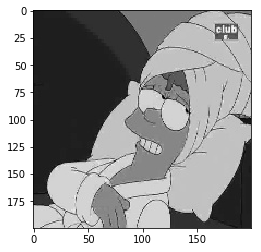

In [2]:
img_src = '/data/examples/simpson_preproc/'

simpson_img = pd.read_csv(img_src + 'simpson_img_list.csv')
print(simpson_img.head())

img = cv2.imread(img_src + simpson_img.img.iloc[0], 0)
plt.imshow(img, cmap='gray')

simpson_img = simpson_img[simpson_img.img.str.contains('simpson')] # filter data

simpson_y = pd.get_dummies(simpson_img['classname'], '').as_matrix() # transform y to one-hot encoder format
print(simpson_y) 

## split dataset to training data and testing data

In [3]:
x_train_list, x_test_list, y_train, y_test = train_test_split(simpson_img, simpson_y, test_size=0.1)  ## 將 input_x 和 input_y 各自區分成 training data 和 testing data

## record the dim of img ##
img = cv2.resize(img, (50,50))
img = img.flatten()

print('input_data shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=(len(x_train_list), img.shape[0]), 
            testing_shape=(len(x_test_list), img.shape[0])))
print('y_true shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=y_train.shape, 
            testing_shape=y_test.shape))

input_data shape: training (6546, 2500) ; testing (728, 2500)
y_true shape: training (6546, 6) ; testing (728, 6)


## define image generator

In [6]:
from sklearn.utils import shuffle 

def simpson_train_batch_generator(x, y, bs, shape):
    x_train = np.array([]).reshape((0, shape))
    y_train = np.array([]).reshape((0, y.shape[1]))
    while True:
        new_ind = shuffle(range(len(x)))
        x = x.take(new_ind)
        y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            dir_img = img_src + x.img.iloc[i]
            img = cv2.imread(dir_img, 0)
            img = cv2.resize(img, (50,50))
            x_train = np.row_stack([x_train, img.flatten()])
            y_train = np.row_stack([y_train, y[i]])
            if x_train.shape[0] == bs:
                x_batch = x_train.copy()
                x_batch /= 255.
                y_batch = y_train.copy()
                x_train = np.array([]).reshape((0 ,shape))
                y_train = np.array([]).reshape((0 ,y.shape[1]))        
                yield x_batch, y_batch

def simpson_test_batch_generator(x, shape):
    x_test = np.array([]).reshape((0, shape))
    for i in range(len(x)):
        dir_img = img_src + x.img.iloc[i]
        img = cv2.imread(dir_img, 0)
        img = cv2.resize(img, (50,50))
        x_test = np.row_stack([x_test, img.flatten()])
    x_test /= 255.      
    return x_test

x_test = simpson_test_batch_generator(x_test_list, img.shape[0])

# create graph
## $\star$$\star$針對regulizer修改$\star$$\star$
1. 多了L2 placeholder
2. 每一層layer也都多輸入了kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2)
3. 增加reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
4. loss 變數多了tf.reduce_sum(reg)

In [1]:
#### define placeholder ####
tf.reset_default_graph() ## 重新 build graph 需要跑這行

input_data = tf.placeholder(dtype=tf.float32, 
                           shape=[None, img.shape[0]],
                           name='input_data')

y_true = tf.placeholder(dtype=tf.float32, 
                        shape=[None, y_train.shape[1]],
                        name='y_true')
#新增l2 placeholder
l2 = tf.placeholder(dtype=tf.float32, name = 'l2_regulizers')  

#### define variables(weight/bias) ####
x1 = tf.layers.dense(input_data, 
                     256, 
                     activation=tf.nn.relu, 
                     name='hidden1', 
                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
x2 = tf.layers.dense(x1, 
                     128, 
                     activation=tf.nn.relu, 
                     name='hidden2',
                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
x3 = tf.layers.dense(x2, 
                     64, 
                     activation=tf.nn.relu, 
                     name='hidden3',
                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
out = tf.layers.dense(x3, y_train.shape[1], name='output')

y_pred = tf.nn.softmax(out)

#### calculate loss ####
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=out))

#### optimize variables ####
opt = tf.train.AdamOptimizer(learning_rate=0.001)

reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = cross_entropy + tf.reduce_sum(reg)
update = opt.minimize(loss)
    
# grad = opt.compute_gradients(loss)
# update = opt.apply_gradients(grad)

NameError: name 'tf' is not defined

# run session
## $\star$$\star$針對regulizer修改$\star$$\star$
sess.run 中變數多增加了l2
### we can simply run the session multiple times with different amount of regulizers

In [2]:
from tqdm import tqdm_notebook
import time
from sklearn.metrics import accuracy_score

epoch = 100 #100
bs = 32
update_per_epoch = 100
g_train_loss, g_valid_loss = [], []
g_train_acc, g_valid_acc = [], []

for l2_iter in [0.0, 0.5, 0.05, 0.005, 0.0005]:
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    tr_loss = list()
    te_loss = list()
    tr_acc = list()
    te_acc = list()
    train_gen = simpson_train_batch_generator(x_train_list, y_train, bs, img.shape[0])

    print('start modelling!')

    for i in range(epoch):

        #### calculate training loss & update variables ####
        training_loss = 0
        training_acc = 0
        bar = tqdm_notebook(range(update_per_epoch))
        for j in bar:

            x_batch, y_batch = next(train_gen)

            tr_pred, training_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict={
                input_data:x_batch,
                y_true:y_batch,
                l2: l2_iter
            })

            training_loss += training_loss_batch

            training_acc_batch = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(tr_pred, axis=1))
            training_acc += training_acc_batch

            if j % 5 == 0:
                pass
                #bar.set_description('loss: %.4g' % training_loss_batch)

        ###
        training_loss /= update_per_epoch
        training_acc /= update_per_epoch

        #### calculate testing data loss ####
        te_pred, testing_loss = sess.run([y_pred, loss], feed_dict={
            input_data:x_test,
            y_true:y_test,
            l2: l2_iter
        })

        testing_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(te_pred, axis=1))

        tr_loss.append(training_loss)
        te_loss.append(testing_loss)
        tr_acc.append(training_acc)
        te_acc.append(testing_acc)

        print('epoch {epochs}: training loss {training_loss} ; testing loss {testing_loss}'.format(
                epochs=(i+1), 
                training_loss=training_loss,
                testing_loss=testing_loss))
        
    sess.close()
    g_train_loss.append(tr_loss)
    g_valid_loss.append(te_loss)
    g_train_acc.append(tr_acc)
    g_valid_acc.append(te_acc)


NameError: name 'tf' is not defined

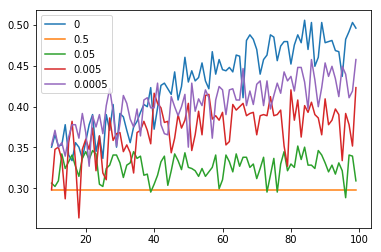

In [10]:
skp = 10
f, axarr = plt.subplots(2, 3, figsize = (8, 6))
axarr[0, 0].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[0][skp:], label = '0')
axarr[0, 0].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[0][skp:], label = '0')
axarr[0, 0].set_title("l2 = 0")

axarr[0, 1].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[1][skp:], label = '0.5')
axarr[0, 1].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[1][skp:], label = '0.5')
axarr[0, 1].set_title("l2 = 0.5")

axarr[0, 2].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[2][skp:], label = '0.05')
axarr[0, 2].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[2][skp:], label = '0.05')
axarr[0, 2].set_title("l2 = 0.05")

axarr[1, 0].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[3][skp:], label = '0.005')
axarr[1, 0].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[3][skp:], label = '0.005')
axarr[1, 0].set_title("l2 = 0.005")

axarr[1, 1].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[4][skp:], label = '0.0005')
axarr[1, 1].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[4][skp:], label = '0.0005')
axarr[1, 1].set_title("l2 = 0.0005")
#f.subplots_adjust(hspace = 0.5)
plt.tight_layout()
plt.show()

plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[0][skp:], label = '0')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[1][skp:], label = '0.5')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[2][skp:], label = '0.05')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[3][skp:], label = '0.005')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[4][skp:], label = '0.0005')
plt.legend(loc='best')
plt.show()